In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis, norm, pearsonr, spearmanr
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [33]:
df = pd.read_csv("AirPassengers.csv")
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [35]:
df.describe()

,#Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


In [36]:
df = df.set_index("Month")

In [37]:
df.index = pd.to_datetime(df.index)

In [38]:
df.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


<Axes: xlabel='Month'>

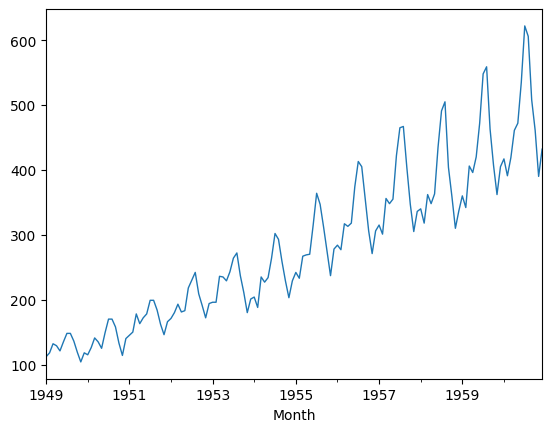

In [39]:
df['#Passengers'].plot(linewidth=1)

In [40]:
df.describe()

,#Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   #Passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


In [42]:
# rolling_mean = df.rolling(window=12).mean()

# rolling_std = df.rolling(12).std()
# print(rolling_mean, rolling_std)

Determining whether the dates are stationary or non-stationary

In [43]:
# To check if data is stationary or not
from statsmodels.tsa.stattools import adfuller

fuller = adfuller(df["#Passengers"].dropna())
print(f"\nADF Statistic for #Passengers: {fuller[0]}")
print(f"p-value: {fuller[1]}")
if round(fuller[1], 2) <= 0.05:
    print("Series #Passengers is stationary")
else :
    print("Series #Passengers is Non-stationary")


ADF Statistic for #Passengers: 0.8153688792060482
p-value: 0.991880243437641
Series #Passengers is Non-stationary


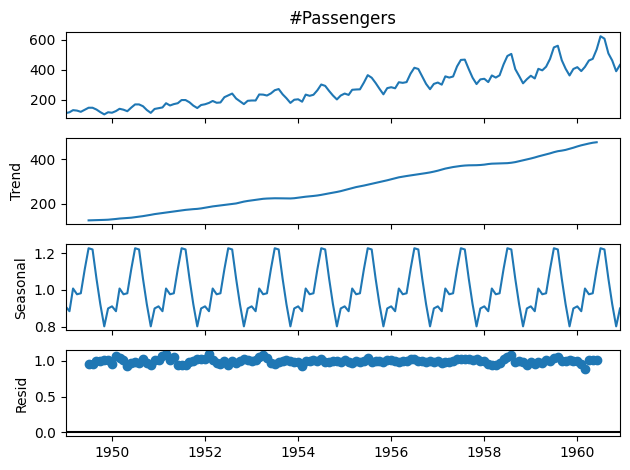

In [44]:
import statsmodels.api as sm

dec = sm.tsa.seasonal_decompose(df['#Passengers'],period = 12, model = 'multiplicative').plot()
plt.show()

#### Using Seasonal Differencing

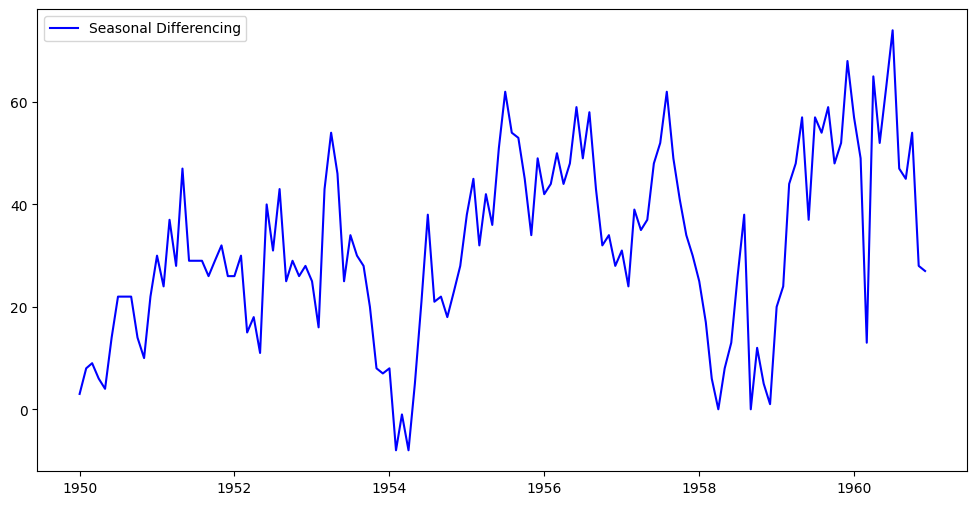

ADF Statistic after seasonal differencing: -3.38
p-value: 0.01


In [14]:
df['Seasonal_Diff'] = df['#Passengers'].diff(periods=12)

plt.figure(figsize=(12,6))
plt.plot(df['Seasonal_Diff'], label='Seasonal Differencing', color='blue')
plt.legend()
plt.show()

# print("ADF Test after Seasonal Differencing:")
adf_test = adfuller(df['Seasonal_Diff'].dropna())
print(f"ADF Statistic after seasonal differencing: {adf_test[0]:.2f}")
print(f"p-value: {adf_test[1]:.2f}")

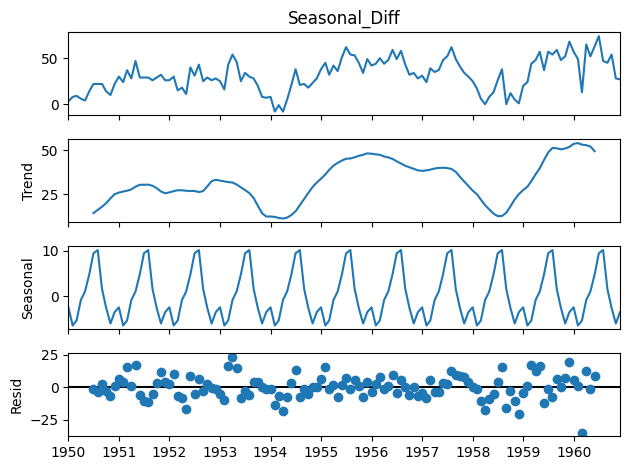

In [15]:
# data_diff = df.diff().dropna()

dec = sm.tsa.seasonal_decompose(df['Seasonal_Diff'].dropna(), period = 12).plot()
plt.show()

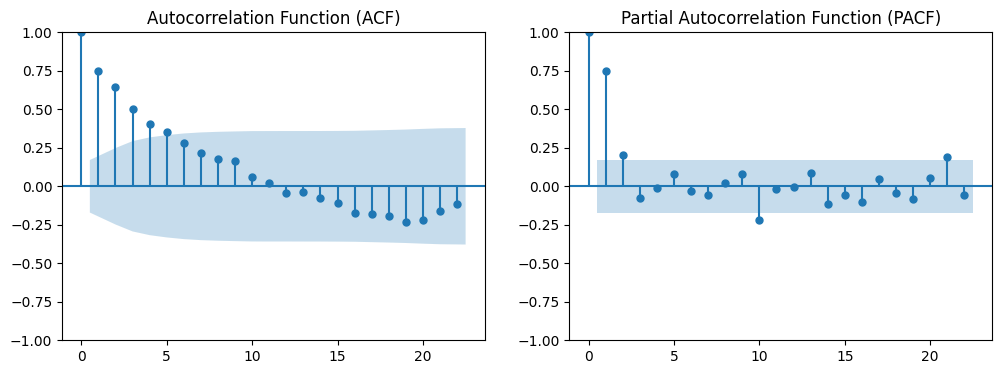

In [16]:
# import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# ACF Plot (for MA terms)
plot_acf(df["Seasonal_Diff"].dropna(), ax=ax[0])
ax[0].set_title("Autocorrelation Function (ACF)")

# PACF Plot (for AR terms)
plot_pacf(df["Seasonal_Diff"].dropna(), ax=ax[1])
ax[1].set_title("Partial Autocorrelation Function (PACF)")

plt.show()

In [17]:
train = df.iloc[0:108]
test = df.iloc[108:]

In [69]:
# plt.plot(train, label='Train Data')
# plt.plot(test, label='Test Data', color='red')
# plt.legend()
# plt.show()

In [18]:
train = train.asfreq("MS")

model = SARIMAX(train["#Passengers"], order=(2,1,2), seasonal_order=(0,1,1,12))
model_sarima = model.fit()
test.loc[:, "SARIMA_Predictions"] = model_sarima.forecast(steps=len(test)).values

C:\Users\Kolade\AppData\Local\Temp\ipykernel_15852\823004543.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, "SARIMA_Predictions"] = model_sarima.forecast(steps=len(test)).values


In [19]:
# model_sarima = SARIMAX(train['Passengers'], order=(2,1,2), seasonal_order=(1,1,1,12))
# model_sarima_fit = model_sarima.fit()
# test['SARIMA_Predictions'] = model_sarima_fit.forecast(steps=24)

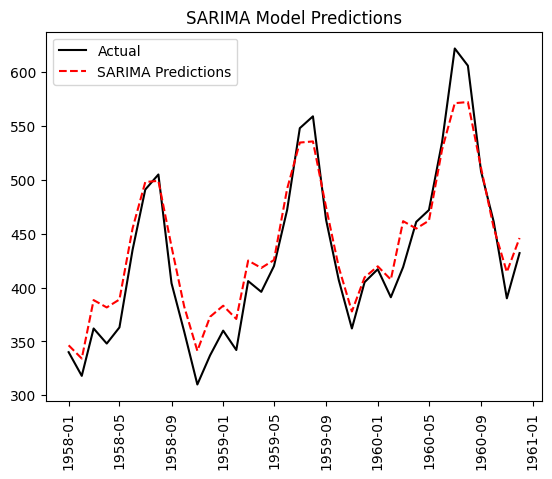

In [20]:
# plt.figure(figsize=(10, 4))
plt.plot(test['#Passengers'], label='Actual', color='black')
plt.plot(test['SARIMA_Predictions'], label='SARIMA Predictions', linestyle='dashed', color='red')
plt.title("SARIMA Model Predictions")
plt.xticks(rotation=90)
plt.legend()
plt.show()

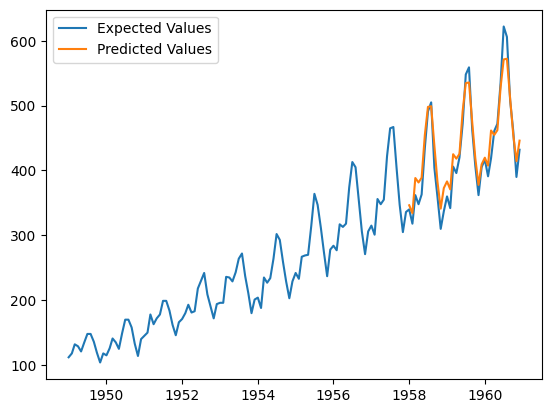

In [21]:
# predictions_series = pd.Series(predictions, index = test.index)
# fig,ax = plt.subplots(nrows = 1,ncols = 1,figsize = (15,5))

plt.subplot(1,1,1)
plt.plot(df['#Passengers'], label = 'Expected Values')
plt.plot(test['SARIMA_Predictions'], label = 'Predicted Values');
plt.legend(loc="upper left")
plt.show()

In [22]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

error = np.sqrt(mean_squared_error(test['#Passengers'], test['SARIMA_Predictions']))
MSE = mean_squared_error(test['#Passengers'], test['SARIMA_Predictions'])
print('Test RMSE: %.4f' % error)
print('Test MSE: %.4f' % MSE)

Test RMSE: 22.3357
Test MSE: 498.8843


In [23]:
r2 = r2_score(test['#Passengers'], test['SARIMA_Predictions'])
print(f"R² : {r2:.4f}")

R² : 0.9185
